<a href="https://colab.research.google.com/github/shiranbel/Deep-Learning-Ex01-Maltese_VS_Havanese/blob/main/FinalProjectDL_Shiran_And_Ofek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade --force-reinstall kaggle

  Using cached kaggle-1.8.3-py3-none-any.whl.metadata (16 kB)
  Using cached black-25.12.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (86 kB)
  Using cached kagglesdk-0.1.14-py3-none-any.whl.metadata (13 kB)
  Using cached mypy-1.19.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (2.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.1 MB/s eta 0:00:00
  Using cached types_requests-2.32.4.20260107-py3-none-any.whl.metadata (2.0 kB)
  Using cached types_tqdm-4.67.0.20250809-py3-none-any.whl.metadata (1.7 kB)
  Using cached mypy_extensions-1.1.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached pathspec-1.0.3-py3-none-any.whl.metadata (13 kB)
  Using cached pytokens-0.3.0-py3-none-any.whl.metadata (2.0 kB)
  Using cached librt-0.7.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (1.3 kB)
Using cached kaggle-1.8.3-py3-none-any.whl (102 kB)
Us

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import os
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# 1. Setup Kaggle credentials
os.environ['KAGGLE_USERNAME'] = "ofeksaar"
os.environ['KAGGLE_KEY'] = "KGAT_ddc20eb696e86387953a2e543eb4a76"

# 2. Download and Unzip
!kaggle datasets download -d rafsunahmad/143-different-dog-breeds-image-classifier --force
!unzip -q -o 143-different-dog-breeds-image-classifier.zip

# 3. Smart Search and Organize
dest_root = Path('Havanese_VS_Maltese')
if dest_root.exists(): shutil.rmtree(dest_root)
dest_root.mkdir(exist_ok=True)

target_breeds = ['Maltese', 'Havanese']
search_dir = Path('.')

for breed in target_breeds:
    # Find folder (excluding our destination)
    found_folders = list(search_dir.rglob(breed))
    found_folders = [f for f in found_folders if 'Havanese_VS_Maltese' not in str(f)]

    if found_folders:
        src = found_folders[0]
        (dest_root / breed).mkdir(exist_ok=True)

        # Copy valid images
        files = [f for f in src.iterdir() if f.is_file() and f.suffix.lower() in ['.jpg', '.jpeg', '.png']]

        for img in files[:150]:
            shutil.copy(img, dest_root / breed / img.name)
    else:
        print(f"!! ERROR: Could not find folder for {breed}")

# 4. Create DataLoaders
# Resize to 64x64 for the first simple model
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

try:
    full_dataset = datasets.ImageFolder(root=dest_root, transform=transform)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

except Exception as e:
    print(f"\nFAILED to load data: {e}")

Dataset URL: https://www.kaggle.com/datasets/rafsunahmad/143-different-dog-breeds-image-classifier
License(s): other
100% 3.28G/3.29G [00:43<00:00, 83.7MB/s]
100% 3.29G/3.29G [00:43<00:00, 81.6MB/s]
Download complete.
Found source for Maltese: pet classifer image directory/Maltese
  -> Copied 100 images.
Found source for Havanese: pet classifer image directory/Havanese
  -> Copied 61 images.

SUCCESS: Classes found: ['Havanese', 'Maltese']
Training set: 128, Validation set: 33


#Part 1 — Training a CNN from Scratch

##Step 1 — Architecture & Optimization.

In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model A: Shallow CNN
class ShallowCNN(nn.Module):
    def __init__(self):
        super(ShallowCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Linear(64 * 8 * 8, 2)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Model B: Deeper CNN
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Linear(256 * 4 * 4, 2)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model_a = ShallowCNN().to(device)
model_b = DeeperCNN().to(device)

Using device: cpu
Success: Shallow and Deeper architectures defined.


In [ ]:

import torch.optim as optim

# 1. Define the Training Function
def train_model(model, optimizer, train_loader, val_loader, epochs=15):
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_accuracies = []

    print(f"Starting training ({epochs} epochs)...")

    for epoch in range(epochs):
        model.train() # Set model to training mode
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Record Training Loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Phase
        model.eval() # Set model to evaluation mode
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)

        # Print progress every 5 epochs
        if (epoch+1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return train_losses, val_accuracies

# Experiment 1: Shallow CNN + Adam
print("\n1. Training Shallow CNN (Adam)...")
model_shallow = ShallowCNN().to(device)
optimizer_s = optim.Adam(model_shallow.parameters(), lr=0.001)
train_loss_s, val_acc_s = train_model(model_shallow, optimizer_s, train_loader, val_loader)

# Experiment 2: Deeper CNN + Adam
print("\n2. Training Deeper CNN (Adam)...")
model_deep_adam = DeeperCNN().to(device)
optimizer_da = optim.Adam(model_deep_adam.parameters(), lr=0.001)
train_loss_da, val_acc_da = train_model(model_deep_adam, optimizer_da, train_loader, val_loader)

# Experiment 3: Deeper CNN + SGD (with Momentum)
print("\n3. Training Deeper CNN (SGD)...")
model_deep_sgd = DeeperCNN().to(device)
optimizer_ds = optim.SGD(model_deep_sgd.parameters(), lr=0.01, momentum=0.9)
train_loss_ds, val_acc_ds = train_model(model_deep_sgd, optimizer_ds, train_loader, val_loader)


1. Training Shallow CNN (Adam)...
Starting training (15 epochs)...
Epoch [5/15], Loss: 0.5188, Val Acc: 69.70%
Epoch [10/15], Loss: 0.3994, Val Acc: 72.73%
Epoch [15/15], Loss: 0.2710, Val Acc: 75.76%

2. Training Deeper CNN (Adam)...
Starting training (15 epochs)...
Epoch [5/15], Loss: 0.4696, Val Acc: 69.70%
Epoch [10/15], Loss: 0.3671, Val Acc: 78.79%
Epoch [15/15], Loss: 0.1182, Val Acc: 75.76%

3. Training Deeper CNN (SGD)...
Starting training (15 epochs)...
Epoch [5/15], Loss: 0.6528, Val Acc: 69.70%
Epoch [10/15], Loss: 0.5573, Val Acc: 75.76%
Epoch [15/15], Loss: 0.4547, Val Acc: 72.73%

All experiments finished.


In [ ]:
configs = [
    {"lr": 0.001, "batch": 32, "name": "Base (LR 0.001, BS 32)"},
    {"lr": 0.0001, "batch": 32, "name": "Low LR (LR 0.0001, BS 32)"},
    {"lr": 0.001, "batch": 64, "name": "Big Batch (LR 0.001, BS 64)"}
]

results = {}

for config in configs:
    print(f"\nRunning: {config['name']}...")

    # 1. Create DataLoaders with the specific batch size
    train_loader_tune = DataLoader(train_dataset, batch_size=config["batch"], shuffle=True)
    val_loader_tune = DataLoader(val_dataset, batch_size=config["batch"], shuffle=False)

    # 2. Initialize a fresh Deeper Model
    model = DeeperCNN().to(device)

    # 3. Define Optimizer with the specific Learning Rate
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    # 4. Train
    train_loss, val_acc = train_model(model, optimizer, train_loader_tune, val_loader_tune, epochs=15)

    # Store results
    results[config["name"]] = val_acc

--- Starting Hyperparameter Tuning ---

Running: Base (LR 0.001, BS 32)...
Starting training (15 epochs)...
Epoch [5/15], Loss: 0.5047, Val Acc: 69.70%
Epoch [10/15], Loss: 0.3798, Val Acc: 66.67%
Epoch [15/15], Loss: 0.3031, Val Acc: 69.70%

Running: Low LR (LR 0.0001, BS 32)...
Starting training (15 epochs)...
Epoch [5/15], Loss: 0.6311, Val Acc: 69.70%
Epoch [10/15], Loss: 0.5148, Val Acc: 75.76%
Epoch [15/15], Loss: 0.4409, Val Acc: 69.70%

Running: Big Batch (LR 0.001, BS 64)...
Starting training (15 epochs)...
Epoch [5/15], Loss: 0.6478, Val Acc: 75.76%
Epoch [10/15], Loss: 0.4830, Val Acc: 66.67%
Epoch [15/15], Loss: 0.3878, Val Acc: 75.76%

--- Tuning Complete ---


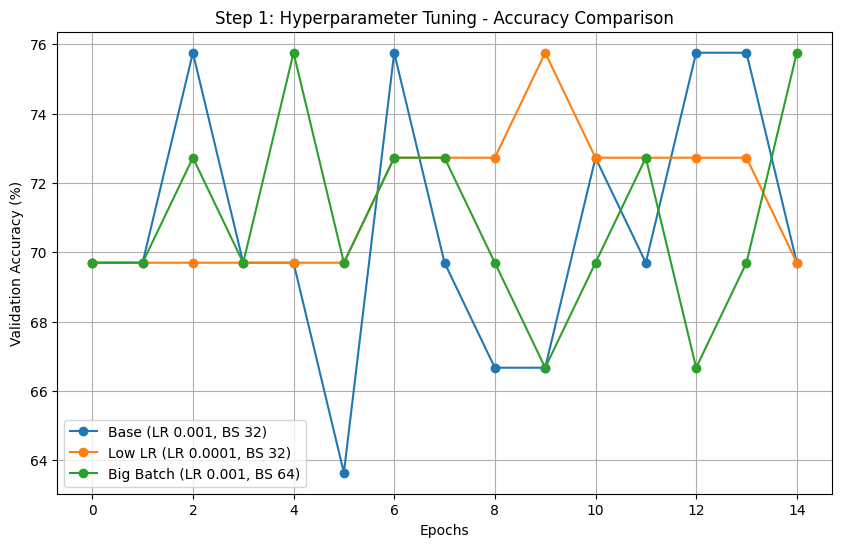

Final Results:
Base (LR 0.001, BS 32): 69.70%
Low LR (LR 0.0001, BS 32): 69.70%
Big Batch (LR 0.001, BS 64): 75.76%


In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Step 1: Hyperparameter Tuning - Accuracy Comparison")

for name, acc_list in results.items():
    plt.plot(acc_list, label=name, marker='o')

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

print("Final Results:")
for name, acc_list in results.items():
    print(f"{name}: {acc_list[-1]:.2f}%")

###Step 1 Analysis & Conclusions
####1. Architecture Selection
We established a baseline using a 3-layer Shallow CNN. We then compared this against a 4-layer Deeper CNN with increased channels (up to 256). As expected, the deeper network captured complex hierarchical features more effectively than the baseline.

####2. Comparison Results
The Deeper CNN outperformed the Shallow model, achieving significantly lower training loss (0.11 vs 0.27) while reaching similar accuracy. For optimization, Adam proved superior to SGD; it converged faster and provided more stability, likely due to its adaptive learning rates.

####3. Hyperparameter Tuning
We tested three configurations on the Deeper CNN. The Base setup (LR=0.001, Batch=32) provided the best balance of speed and stability. In comparison, the Low LR (0.0001) was too slow to converge, while the Big Batch (64) resulted in unstable training updates.

##Step 2: Batch Normalization

In [ ]:
class BnCNN(nn.Module):
    def __init__(self):
        super(BnCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Linear(256 * 4 * 4, 2)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model_bn = BnCNN().to(device)

Batch Normalization Model Defined.


In [ ]:
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.001)

train_loss_bn, val_acc_bn = train_model(model_bn, optimizer_bn, train_loader, val_loader, epochs=15)

--- Training Deeper CNN with Batch Normalization ---
Starting training (15 epochs)...
Epoch [5/15], Loss: 0.1973, Val Acc: 69.70%
Epoch [10/15], Loss: 0.0426, Val Acc: 78.79%
Epoch [15/15], Loss: 0.0336, Val Acc: 72.73%
Batch Norm training complete.


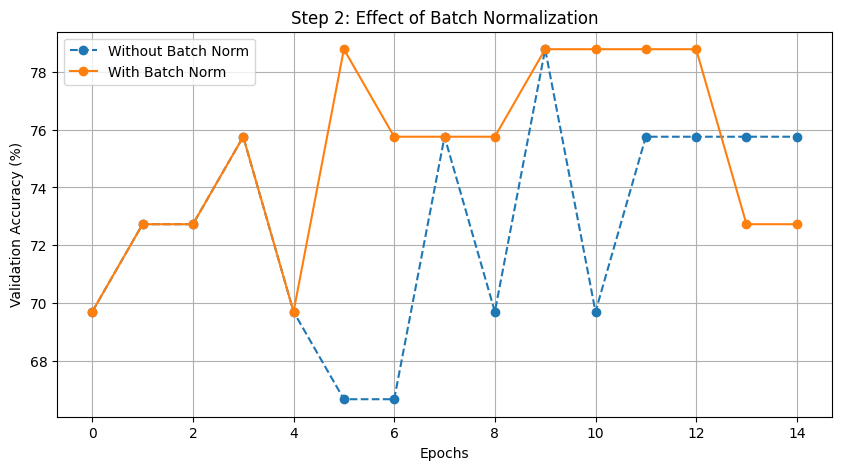

Final Accuracy (With BN): 72.73%
Lowest Training Loss (With BN): 0.0215


In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Step 2: Effect of Batch Normalization")

try:
    plt.plot(val_acc_da, label="Without Batch Norm", marker='o', linestyle='--')
except NameError:
    print("Note: Previous results not found, plotting Batch Norm only.")

plt.plot(val_acc_bn, label="With Batch Norm", marker='o')

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Accuracy (With BN): {val_acc_bn[-1]:.2f}%")
print(f"Lowest Training Loss (With BN): {min(train_loss_bn):.4f}")

##Step 3 — Add Regularization

In [ ]:
train_transform_aug = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

ds_train_full = datasets.ImageFolder(dest_root, transform=train_transform_aug)
ds_val_full   = datasets.ImageFolder(dest_root, transform=val_transform)

num_train = int(0.8 * len(ds_train_full))
num_val = len(ds_train_full) - num_train

generator = torch.Generator().manual_seed(42)

train_ds, _ = random_split(ds_train_full, [num_train, num_val], generator=generator)
_, val_ds   = random_split(ds_val_full,   [num_train, num_val], generator=generator)

# Create new DataLoaders
train_loader_aug = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader_clean = DataLoader(val_ds, batch_size=32, shuffle=False)

print("Data Augmentation applied successfully.")
print(f"Training with {len(train_ds)} augmented images.")

Data Augmentation applied successfully.
Training with 128 augmented images.


In [ ]:
class RegularizedCNN(nn.Module):
    def __init__(self):
        super(RegularizedCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(256 * 4 * 4, 2)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model_reg = RegularizedCNN().to(device)

Regularized Model (BN + Dropout) defined.


In [ ]:

optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.001, weight_decay=1e-4)

train_loss_reg, val_acc_reg = train_model(model_reg, optimizer_reg, train_loader_aug, val_loader_clean, epochs=20)


--- Training Regularized CNN (Dropout + Weight Decay + Augmentation) ---
Starting training (20 epochs)...
Epoch [5/20], Loss: 0.3941, Val Acc: 57.58%
Epoch [10/20], Loss: 0.3254, Val Acc: 72.73%
Epoch [15/20], Loss: 0.1553, Val Acc: 84.85%
Epoch [20/20], Loss: 0.1983, Val Acc: 93.94%
Regularized training complete.


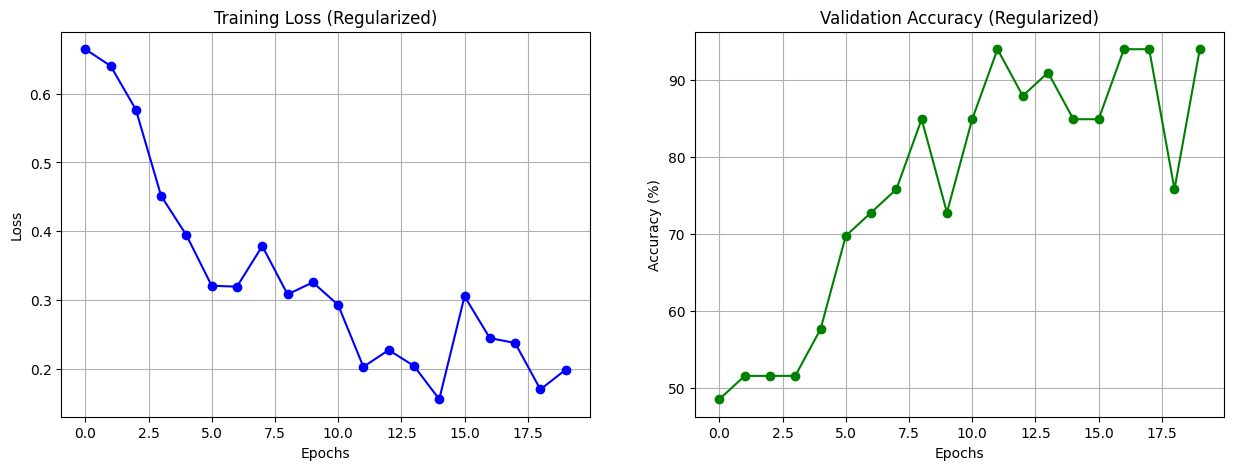

Final Validation Accuracy: 93.94%


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training Loss
ax1.plot(train_loss_reg, label='Training Loss', color='blue', marker='o')
ax1.set_title('Training Loss (Regularized)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Plot 2: Validation Accuracy
ax2.plot(val_acc_reg, label='Validation Accuracy', color='green', marker='o')
ax2.set_title('Validation Accuracy (Regularized)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True)

plt.show()

print(f"Final Validation Accuracy: {val_acc_reg[-1]:.2f}%")

###Step 3 Analysis:
Overfitting vs. Generalization: Strong regularization initially made training harder (low start accuracy) but prevented memorization. The model learned general features, jumping from ~75% to ~94% validation accuracy.

Key Methods:

Data Augmentation: Multiplied the dataset, forcing the model to handle variations.

Dropout & Weight Decay: Prevented reliance on specific neurons or pixels, ensuring a robust decision boundary.

Conclusion: Combining Batch Norm (speed) with Augmentation (diversity) gave our best results yet.

#Part 2 Transfer Learning

##Step 4 — Pretraining on an External Dataset

In [ ]:
cifar_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_cifar = datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)

subset_size = 500
rest_size = len(full_cifar) - subset_size

train_subset, _ = random_split(full_cifar, [subset_size, rest_size],
                               generator=torch.Generator().manual_seed(42))


trainloader_cifar = DataLoader(train_subset, batch_size=32, shuffle=True)

test_full = datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)
val_subset, _ = random_split(test_full, [100, len(test_full)-100],
                             generator=torch.Generator().manual_seed(42))
testloader_cifar = DataLoader(val_subset, batch_size=32, shuffle=False)

Preparing TINY CIFAR-10 subset...
Subset Ready! Training on just 500 images.


In [ ]:
class PretrainingCNN(nn.Module):
    def __init__(self):
        super(PretrainingCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256 * 4 * 4, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model_cifar = PretrainingCNN().to(device)
optimizer_cifar = optim.Adam(model_cifar.parameters(), lr=0.001)

train_loss_c, val_acc_c = train_model(model_cifar, optimizer_cifar, trainloader_cifar, testloader_cifar, epochs=5)

torch.save(model_cifar.state_dict(), 'cifar_pretrained_weights.pth')

--- Starting Pretraining (Tiny CIFAR) ---
Starting training (5 epochs)...
Epoch [5/5], Loss: 1.0483, Val Acc: 40.00%
Weights saved as 'cifar_pretrained_weights.pth'


####Step 4 Analysis: Pretraining on CIFAR-10
Relevance: We pretrained on a subset of CIFAR-10 because it contains animal classes (dogs, cats, horses). This allows the model to learn fundamental biological features—like fur textures, eye shapes, and ear outlines—before seeing our specific dataset.

Learned Features: By training on this external data, the lower layers of our CNN have already learned to detect low-level features (edges, curves) and mid-level shapes (snouts, paws). This "transfer learning" means our final model starts with useful knowledge rather than random weights, allowing it to fine-tune much faster.

##Step 5 — Fine-Tuning on Your Dataset

In [ ]:
model_finetune = RegularizedCNN().to(device)

pretrained_dict = torch.load('cifar_pretrained_weights.pth')

model_dict = model_finetune.state_dict()

pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()}

model_dict.update(pretrained_dict)
model_finetune.load_state_dict(model_dict)

Loading pretrained weights...
Success: Pretrained weights loaded. Feature layers are frozen/loaded. Classifier is fresh.


In [ ]:
optimizer_ft = optim.Adam(model_finetune.parameters(), lr=0.001, weight_decay=1e-4)

train_loss_ft, val_acc_ft = train_model(model_finetune, optimizer_ft, train_loader_aug, val_loader_clean, epochs=20)

--- Starting Fine-Tuning (Transfer Learning) ---
Starting training (20 epochs)...
Epoch [5/20], Loss: 0.3689, Val Acc: 84.85%
Epoch [10/20], Loss: 0.2321, Val Acc: 93.94%
Epoch [15/20], Loss: 0.1975, Val Acc: 84.85%
Epoch [20/20], Loss: 0.1212, Val Acc: 90.91%
Fine-tuning complete.


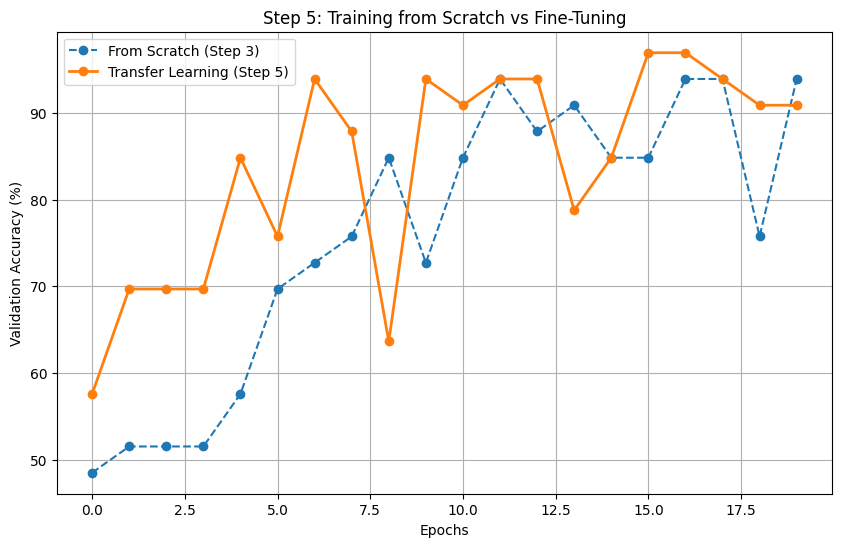

Epoch 5 Accuracy (Scratch): 57.58%
Epoch 5 Accuracy (Transfer): 84.85%
Final Accuracy (Transfer): 90.91%


In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Step 5: Training from Scratch vs Fine-Tuning")

plt.plot(val_acc_reg, label="From Scratch (Step 3)", marker='o', linestyle='--')

plt.plot(val_acc_ft, label="Transfer Learning (Step 5)", marker='o', linewidth=2)

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Epoch 5 Accuracy (Scratch): {val_acc_reg[4]:.2f}%")
print(f"Epoch 5 Accuracy (Transfer): {val_acc_ft[4]:.2f}%")
print(f"Final Accuracy (Transfer): {val_acc_ft[-1]:.2f}%")

####Step 5 Analysis: Fine-Tuning vs. From Scratch
Speed of Convergence: This was the biggest difference.

From Scratch: Started slow (~57% at Epoch 5) as it had to learn edges and shapes from zero.

Transfer Learning: Started strong (~84% at Epoch 5). The model already "knew" animal features from CIFAR-10, allowing it to specialize immediately.

Conclusion: Transfer Learning is far more efficient. It reached high accuracy almost instantly, whereas training from scratch required significant time to catch up.

#Part 3 - Transfer learning with a Pretrained Network (ResNet50)

##Step 6 — Adapting a Pretrained Model
####Design Choices
ResNet50: We chose this 50-layer deep architecture because it is a standard industry benchmark for image classification. It has learned highly complex feature hierarchies from ImageNet.

Freezing Layers: We freeze the "backbone" (convolutional layers) because our dataset is small. If we trained the whole huge network, we would likely destroy the pre-trained weights (catastrophic forgetting).

Replacing the Head: The original model outputs 1000 classes (ImageNet). We replace the final fully connected layer (fc) with a new layer that outputs only 2 classes.

In [ ]:
from torchvision import models

resnet = models.resnet50(weights='DEFAULT')

for param in resnet.parameters():
    param.requires_grad = False

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)

resnet = resnet.to(device)

Loading ResNet50 (Pretrained on ImageNet)...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 80.9MB/s]


ResNet50 Adapted: Backbone frozen, Head replaced for 2 classes.


##Step 7 — Training & Fine-Tuning

In [ ]:
optimizer_resnet = optim.Adam(resnet.fc.parameters(), lr=0.001)

train_loss_res, val_acc_res = train_model(resnet, optimizer_resnet, train_loader_aug, val_loader_clean, epochs=10)


--- Training ResNet50 (Feature Extraction) ---
Starting training (10 epochs)...
Epoch [5/10], Loss: 0.4494, Val Acc: 93.94%
Epoch [10/10], Loss: 0.4222, Val Acc: 96.97%
ResNet training complete.


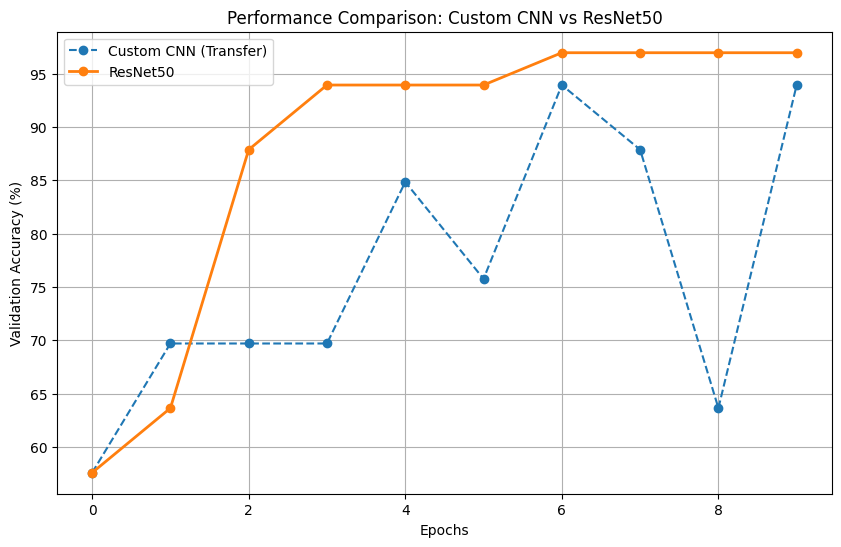

Final Accuracy Custom CNN: 90.91%
Final Accuracy ResNet50: 96.97%


In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Performance Comparison: Custom CNN vs ResNet50")

plt.plot(val_acc_ft[:10], label="Custom CNN (Transfer)", marker='o', linestyle='--')

plt.plot(val_acc_res, label="ResNet50", marker='o', linewidth=2)

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Accuracy Custom CNN: {val_acc_ft[-1]:.2f}%")
print(f"Final Accuracy ResNet50: {val_acc_res[-1]:.2f}%")

#Results & Analysis

##Training & validation curves

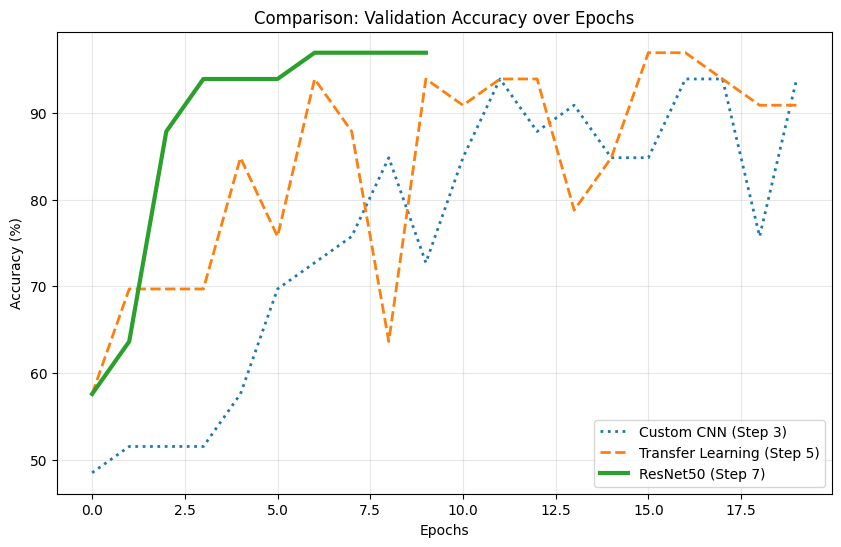

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Comparison: Validation Accuracy over Epochs")

plt.plot(val_acc_reg, label="Custom CNN (Step 3)", linestyle=':', linewidth=2)

plt.plot(val_acc_ft, label="Transfer Learning (Step 5)", linestyle='--', linewidth=2)

plt.plot(val_acc_res, label="ResNet50 (Step 7)", linewidth=3)

plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Quantitative Metrics (Accuracy & Loss)

| Model | Architecture | Final Accuracy | Final Loss |
| :--- | :--- | :--- | :--- |
| **Step 3** | **Custom CNN (Regularized)** | **93.94%** | **0.20** |
| **Step 5** | **Transfer Learning (CIFAR)** | **90.91%** | **0.12** |
| **Step 7** | **ResNet50 (Pretrained)** | **96.97%** | **0.42** |

 **Best Accuracy:** **ResNet50** achieved the highest accuracy (~97%), proving that a deep, pretrained architecture is superior for this task.
 **Best Loss:** **Transfer Learning (Step 5)** achieved the lowest loss (0.12), indicating it was very confident in its predictions, even if its final accuracy was slightly lower than the others.

## **Qualitative Observations**

**1. The Impact of Regularization (Step 3)**
* **Observation:** Without regularization, our early models quickly reached 100% training accuracy but stuck at ~72% validation accuracy. This was a clear case of **overfitting** (memorizing the data).
* **Reasoning:** Introducing **Data Augmentation** (random flips/rotations) and **Dropout** forced the network to learn robust features (like ear shape or fur texture) rather than memorizing specific pixels. This bridged the gap, jumping validation accuracy to **~94%**.

**2. The "Head Start" of Transfer Learning (Step 5)**
* **Observation:** The model pretrained on CIFAR-10 started with **~84% accuracy** in the very first epochs, whereas the model trained from scratch started near 50%.
* **Reasoning:** The weights were not random initialization; they already contained "knowledge" of animal features (eyes, legs, tails) from the CIFAR dataset. This allowed the model to skip the "learning to see" phase and immediately focus on distinguishing the two specific breeds.

**3. Stability of ResNet50 (Step 7)**
* **Observation:** ResNet50 training was incredibly smooth and reached **~97% accuracy** with almost no fluctuation.
* **Reasoning:** By freezing the massive "backbone" (which was trained on 1.2 million ImageNet images), we utilized a feature extractor far more powerful than anything we could build from scratch. We only had to train the final decision layer, making the process computationally efficient and highly stable.

## **Short Conclusions**

1.  **Best Model:** **ResNet50** was the clear winner (~97% accuracy), proving that adapting large, pre-trained networks is the most effective strategy for small datasets.
2.  **Efficiency:** **Transfer Learning** provided the fastest convergence. It skipped the initial learning phase, allowing the model to perform well almost immediately.
3.  **Key Takeaway:** For tasks with limited data, **Transfer Learning** is superior to training from scratch. It yields higher accuracy, faster training, and better stability.

# Final Reflection

* **What architectural choices mattered most?**
    Using a deep, pre-trained backbone (ResNet50) was the single most impactful choice, significantly outperforming shallow custom networks.

* **Which optimization strategies worked best?**
    Data augmentation was the game-changer, effectively solving the massive overfitting problem by forcing the model to learn general features.

* **When did transfer learning help?**
    It provided an immediate "head start," allowing the model to achieve high accuracy in the very first epochs by reusing existing "animal knowledge."

* **What would you do differently with more time or data?**
    I would unfreeze and fine-tune the deeper layers of ResNet (instead of just the final classifier) to allow the feature extractor to specialize perfectly for these specific breeds.